## ScanPy!

This is the easy to use modern gold standard for sequencing analysis in python. Okay lets go. I use the example dataset from the ScanPy website. Let's go.

ScanPy uses AnnData structures, see AnnData Tutorial.

In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import seaborn as sns
import scipy.stats as st
from scipy.sparse import csr_matrix

import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)
rcb.logger.setLevel(logging.ERROR)

%load_ext rpy2.ipython

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


### Reading Data

ScanPy has methods for reading different sequencing files. The one we use is ".h5ad" which is commonly used with ScanPy I think. Here we simply plug in the raw data file paths and call the read function.

In [2]:
# Reading the raw data into a quick dictionary
adatas = {"s1d1": sc.read_10x_h5(r"C:\Users\Johann\Documents\Coding\Python\Master Thesis\Data\s1d1_filtered_feature_bc_matrix.h5"),
          "s1d3": sc.read_10x_h5(r"C:\Users\Johann\Documents\Coding\Python\Master Thesis\Data\s1d3_filtered_feature_bc_matrix.h5")}

adatas["s1d1"].var_names_make_unique()
adatas["s1d3"].var_names_make_unique()

adata = ad.concat(adatas, label= "sample")
adata.obs_names_make_unique() # Because we merge two files, we get duplicates
adata.var_names_make_unique()

# Show size of the two samples
print(adata.obs["sample"].value_counts())

C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata

AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

### Quality Control

We use the function `.calculate_qc_metrics()` to get common QC metrics like:
- Mitochondrial Gene proportion
- Ribosomal genes
- Hemoglobin genes
- gene counts per cell
- cell counts per gene

For this ScanPy has the module Preprocessing or `.pp`.

But first, we need to create some additional QC variable annotations, like which genes are mitochondrial/ribosomal/whatever genes.
Remember, with `adata.var["new annotation"]` we add a row of alternative labels to the columns (variables/genes here). In this case we create 3 new rows that get added as an annotation row on top of the matrix: mitochondrial, ribosomal, and hemoglobin genes.

In [4]:
# mitochondrial genes have "MT-" in the name
# here we simply add an annotation row above the column names (vars)
# to indicate which ones are mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-") # a long boolean list
adata.var[adata.var["mt"]] # this way we can display all the vars (columns/genes) that are TRUE for mitochondrial

adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var[adata.var["ribo"]]

adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]") # regex to filter out hemoglobin genes
adata.var[adata.var["hb"] | adata.var["ribo"] | adata.var["mt"]]

mt   ribo     hb
RPL22    False   True  False
RPL11    False   True  False
RPS6KA1  False   True  False
RPS8     False   True  False
RPL5     False   True  False
...        ...    ...    ...
MT-ND4L   True  False  False
MT-ND4    True  False  False
MT-ND5    True  False  False
MT-ND6    True  False  False
MT-CYB    True  False  False

[128 rows x 3 columns]

Now we calculate the actual QC metrics, including and referring back to the gene subsetting that we just annotated.

In [5]:
# Now we can calculate QC metrics for only the subsets of genes
sc.pp.calculate_qc_metrics(adata, qc_vars= ["mt", "ribo", "hb"],
                           inplace= True,
                           log1p= True)

adata.obs # look, QC metrics get added for each observation, they include the percentage of different gene groups as defined before
# as well as some summaries of gene counts

sample  n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCCAAGGATGGCT-1   s1d1               2103                 7.651596   
AAACCCAAGGCCTAGA-1   s1d1               3916                 8.273081   
AAACCCAAGTGAGTGC-1   s1d1                683                 6.527958   
AAACCCACAAGAGGCT-1   s1d1               4330                 8.373554   
AAACCCACATCGTGGC-1   s1d1                325                 5.786897   
...                   ...                ...                      ...   
TTTGTTGAGAGTCTGG-1   s1d3                277                 5.627621   
TTTGTTGCAGACAATA-1   s1d3               3797                 8.242230   
TTTGTTGCATGTTACG-1   s1d3               3089                 8.035926   
TTTGTTGGTAGTCACT-1   s1d3                379                 5.940171   
TTTGTTGTCGCGCTGA-1   s1d3               1599                 7.377759   

                    total_counts  log1p_total_counts  \
AAACCCAAGGATGGCT-1        8663.0            9.066932   
AAACCCAAGGCCTAGA-1       12853.0            9.461411   
AAACCCAAGTGAGTGC-1        1631.0            7.397562   
AAACCCACAAGAGGCT-1       17345.0            9.761117   
AAACCCACATCGTGGC-1         555.0            6.320768   
...                          ...                 ...   
TTTGTTGAGAGTCTGG-1         615.0            6.423247   
TTTGTTGCAGACAATA-1       13218.0            9.489410   
TTTGTTGCATGTTACG-1       27280.0           10.213945   
TTTGTTGGTAGTCACT-1         698.0            6.549651   
TTTGTTGTCGCGCTGA-1        7358.0            8.903679   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACCCAAGGATGGCT-1                   42.721921                    59.667552   
AAACCCAAGGCCTAGA-1                   35.843772                    44.262040   
AAACCCAAGTGAGTGC-1                   56.284488                    62.599632   
AAACCCACAAGAGGCT-1                   27.662150                    38.420294   
AAACCCACATCGTGGC-1                   49.909910                    59.459459   
...                                        ...                          ...   
TTTGTTGAGAGTCTGG-1                   63.089431                    71.219512   
TTTGTTGCAGACAATA-1                   30.753518                    44.628537   
TTTGTTGCATGTTACG-1                   64.409824                    71.671554   
TTTGTTGGTAGTCACT-1                   52.865330                    60.028653   
TTTGTTGTCGCGCTGA-1                   49.945637                    68.333786   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
AAACCCAAGGATGGCT-1                    69.744892                    79.348955   
AAACCCAAGGCCTAGA-1                    52.376877                    62.763557   
AAACCCAAGTGAGTGC-1                    70.386266                    88.779890   
AAACCCACAAGAGGCT-1                    48.901701                    62.023638   
AAACCCACATCGTGGC-1                    77.477477                   100.000000   
...                                         ...                          ...   
TTTGTTGAGAGTCTGG-1                    87.479675                   100.000000   
TTTGTTGCAGACAATA-1                    53.691935                    64.684521   
TTTGTTGCATGTTACG-1                    78.317449                    85.054985   
TTTGTTGGTAGTCACT-1                    74.355301                   100.000000   
TTTGTTGTCGCGCTGA-1                    76.297907                    85.063876   

                    total_counts_mt  log1p_total_counts_mt  pct_counts_mt  \
AAACCCAAGGATGGCT-1            460.0               6.133398       5.309938   
AAACCCAAGGCCTAGA-1           1790.0               7.490530      13.926710   
AAACCCAAGTGAGTGC-1            581.0               6.366470      35.622318   
AAACCCACAAGAGGCT-1            780.0               6.660575       4.496973   
AAACCCACATCGTGGC-1            159.0               5.075174      28.648647   
...                             ...                    ...            ...   
TTTGTTGAGAGTCTGG-1  

### Determining Outliers with MADs

In addition to filtering out certain gene subsets we want to free our dataset from outliers. While it is possible to simply plot a bunch of QC covariates and eyeball thresholds beyond which to exclude cells, it seems to me more consistent to do it using _STATISTICS_

And that we can do by using **median absolute deviations (MAD)**. Here we define a function that, for a given QC metric, calculates the MAD. Alongside the QC metric we wanna calculate a MAD for, we also pass the number of MADs from the median beyond which we say "nah man". Like n-times standard deviation, we define n-times MAD above and below the median that we deem acceptable.

In [6]:
# Calculating MAD for a given QC metric
def is_outlier(adata, metric: str, nmads: int):
    '''This function calculates whether each element of a list or series is an
    outlier based on the number of median absolute deviations (MADs) passed in the
    arguments nmads. It returns a list of booleans where each element that was an outlier
    in the original list results in a TRUE in the returned list. If you use the returned
    list for indexing to EXCLUDE outliers, remember to index with the inverse (~outliers) of the outlier
    list returned by this function'''
    M = adata.obs[metric]
    outlier = ((M < np.median(M) - nmads * st.median_abs_deviation(M)) # outlier below ...
               | (np.median(M) + nmads * st.median_abs_deviation(M) < M)) # and outlier above
    return outlier

# Defining whether a nucleus is an outlier based on mitochondrial and total counts and percentages
# I dont know why we use the log1p here ...
adata.obs["outlier"] = (is_outlier(adata, "log1p_total_counts", 5) | is_outlier(adata, "log1p_n_genes_by_counts", 5))
adata.obs["mt_outlier"] = (is_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 60))

print(adata.obs["outlier"].value_counts(),
      adata.obs["mt_outlier"].value_counts(),
      sep= "\n\n")

outlier
False    16827
True       298
Name: count, dtype: int64

mt_outlier
False    13243
True      3882
Name: count, dtype: int64


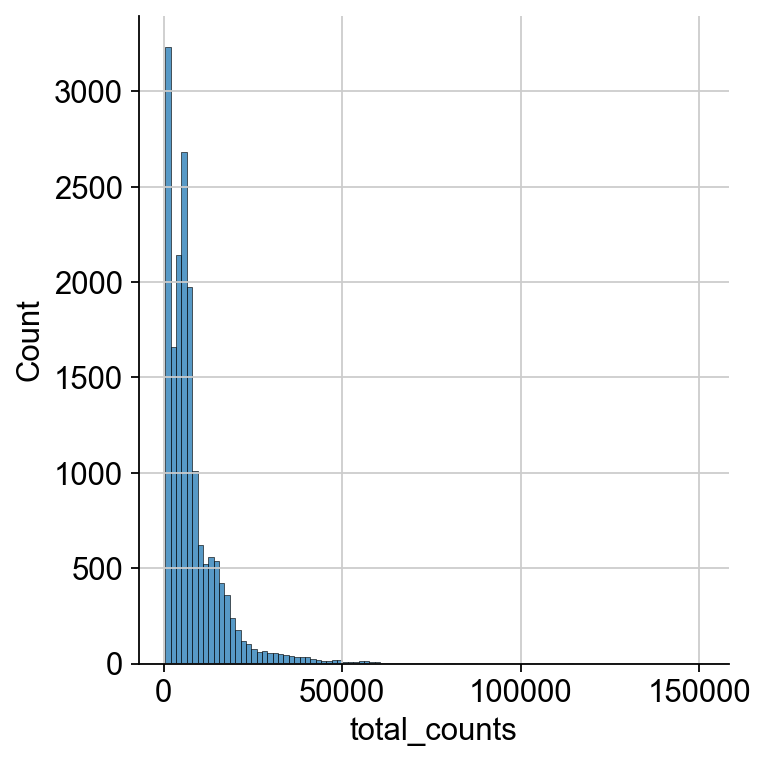

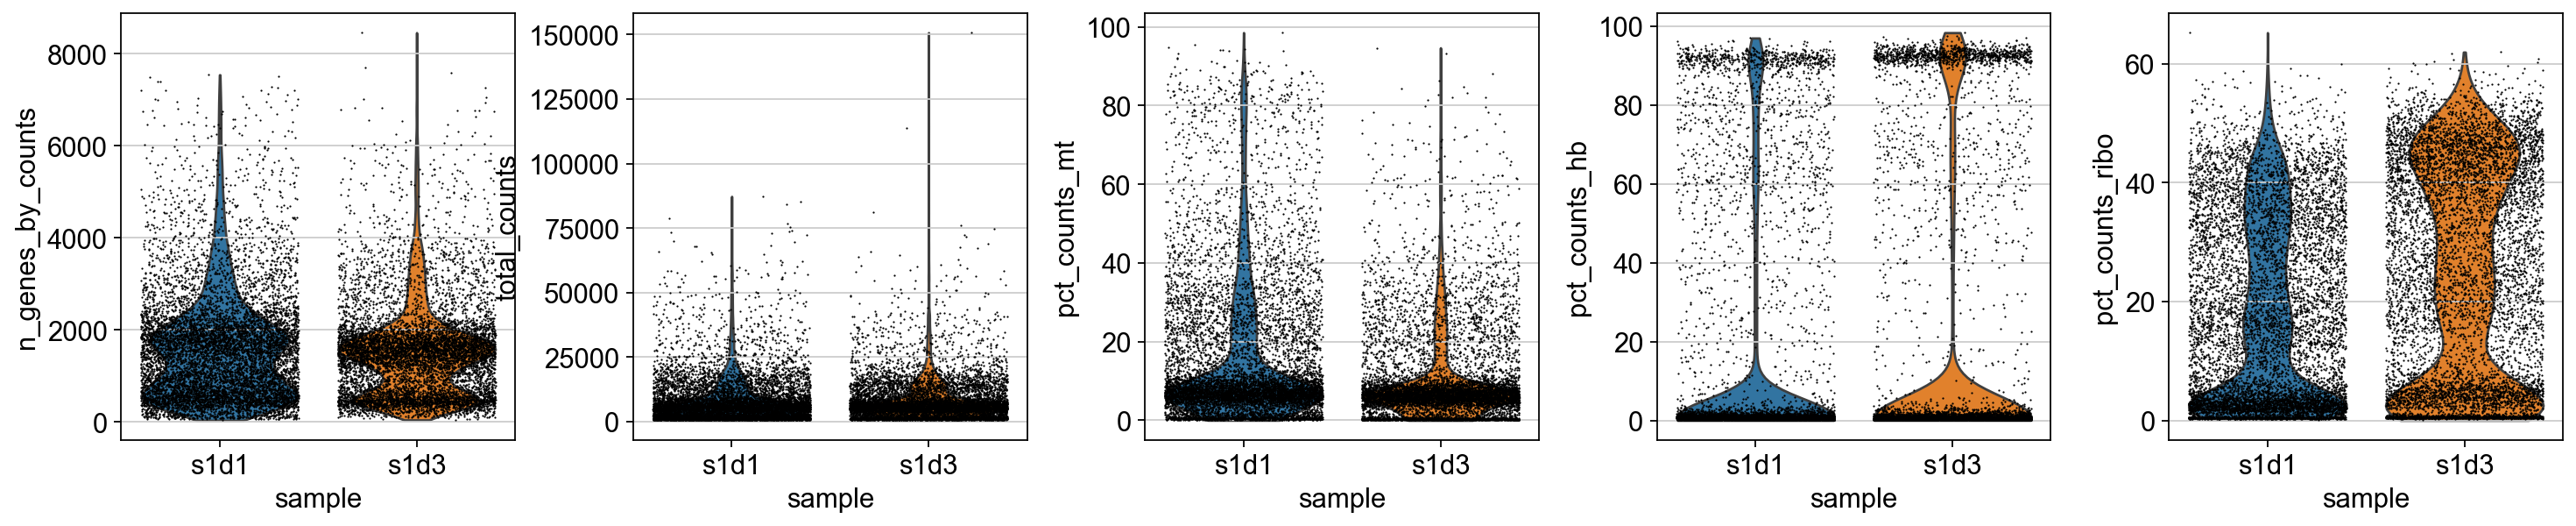

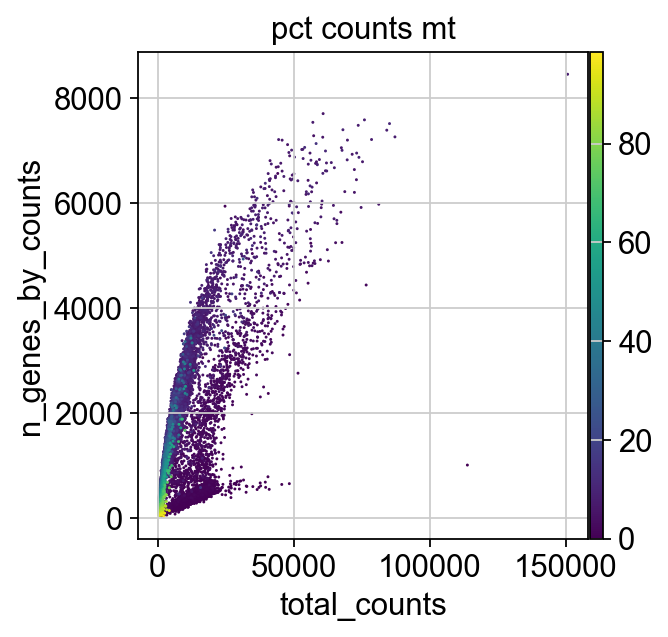

C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


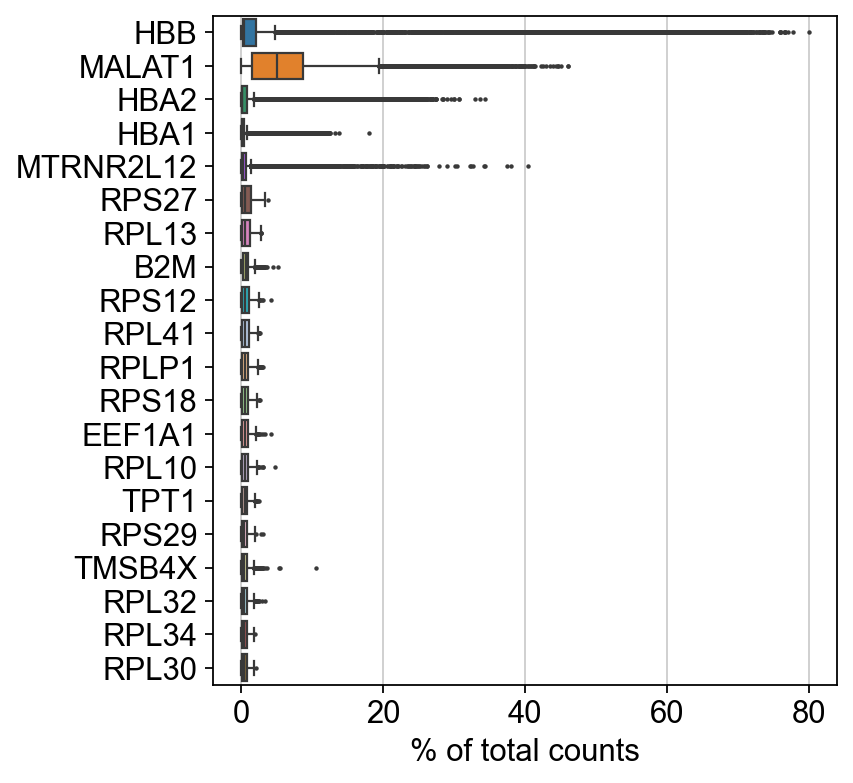

In [7]:
sns.displot(adata.obs["total_counts"], bins = 100, kde= False)

sc.pl.violin(adata,
             ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"],
             jitter= 0.4, # each dot is one cell/nucleus
             multi_panel= True,
             groupby= "sample") # you can group by observation labels

# mitochondrial content
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# most highly expressed genes just for checking
sc.pl.highest_expr_genes(adata[:, adata.var["mt"] == False], n_top=20)

### Filtering

Now we use the QC metrics (gene subsets as well as the outliers) that we just calculated to actually filter out cells and genes from the count matrix.

For this you could use simply slicing by observation (qc metric) or the specific `.filter_cells` and `.filter_genes` methods.

In [8]:
# You could do it like this and simply save the view (the subset) to a new variable
adata[adata.obs["n_genes_by_counts"] >= 100].to_df()
adata[:, adata.var["n_cells_by_counts"] >= 3].to_df()

# And this is also what we have to do with out custom "outlier" annotations
print(f"Number of cells before outliers: {adata.n_obs}")
adata = adata[(~adata.obs["outlier"]) & (~adata.obs["mt_outlier"])]
print(f"Number of cells after outliers: {adata.n_obs}\n")

# Or there's extra functions for exclusions
print(f"Number of cells before count exclusion: {adata.n_obs}")
sc.pp.filter_cells(adata, min_genes= 100, inplace= True)
sc.pp.filter_genes(adata, min_cells= 20, inplace= True)
print(f"Number of cells after count exclusion: {adata.n_obs}")

adata #dimensions match regardless which you use

# And if we check again now
adata[adata.obs["n_genes_by_counts"] < 100].to_df() # Theres nothing in there anymore! (inplace= True, also)
adata[:, adata.var["n_cells_by_counts"] < 20].to_df() # Here neither

Number of cells before outliers: 17125
Number of cells after outliers: 13194

Number of cells before count exclusion: 13194


C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\preprocessing\_simple.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


Number of cells after count exclusion: 13194


Empty DataFrame
Columns: []
Index: [AAACCCAAGGATGGCT-1, AAACCCAAGGCCTAGA-1, AAACCCACAAGAGGCT-1, AAACCCAGTCCGCAGT-1, AAACCCAGTGCATACT-1, AAACCCATCGGAGCAA-1, AAACGAAAGCAATTCC-1, AAACGAACAAGAATAC-1, AAACGAACACAGGATG-1, AAACGAACATCGCTGG-1, AAACGAAGTAAGTTAG-1, AAACGAAGTCCACTTC-1, AAACGAAGTCTCACAA-1, AAACGAAGTTTGCAGT-1, AAACGAATCCCTTGGT-1, AAACGAATCGCTCCTA-1, AAACGAATCGTGCACG-1, AAACGCTAGAAGTCAT-1, AAACGCTAGAGCCTGA-1, AAACGCTAGAGGTCGT-1, AAACGCTAGGCAGTCA-1, AAACGCTAGTAGAGTT-1, AAACGCTAGTCAGAGC-1, AAACGCTCAAGCCTGC-1, AAACGCTCATGCAGGA-1, AAACGCTGTACTTGTG-1, AAACGCTGTCTCTCAC-1, AAACGCTGTTCGGTAT-1, AAACGCTTCACCTACC-1, AAACGCTTCACTACTT-1, AAACGCTTCACTAGCA-1, AAAGAACAGCTCCCTT-1, AAAGAACAGGGACTGT-1, AAAGAACCATCAGTCA-1, AAAGGATCACGTCGGT-1, AAAGGATGTATATGGA-1, AAAGGATGTTCCCAAA-1, AAAGGATGTTGAGGAC-1, AAAGGATTCCCATGGG-1, AAAGGATTCTACGGGC-1, AAAGGGCAGGACGGAG-1, AAAGGGCAGGCACGAT-1, AAAGGGCAGTTTCAGC-1, AAAGGGCGTAACGTTC-1, AAAGGGCGTCCACGCA-1, AAAGGGCGTGTCGCTG-1, AAAGGGCTCACTGGTA-1, AAAGGTACAACTCATG-1, AAAGGTAGTAGTGCGA-1, AAAGGTATCAAGTAAG-1, AAAGGTATCGAGAGCA-1, AAAGTCCAGAATCTAG-1, AAAGTCCAGCACGTCC-1, AAAGTCCGTACGATCT-1, AAAGTCCGTACTCAAC-1, AAAGTCCGTAGACAAT-1, AAAGTCCGTCAACCAT-1, AAAGTCCTCTGTCCCA-1, AAAGTCCTCTTGCAAG-1, AAAGTGAAGAAGGGAT-1, AAAGTGACAACACGTT-1, AAAGTGAGTAACGCGA-1, AAAGTGAGTCGTACTA-1, AAAGTGAGTTTCCCAC-1, AAAGTGAGTTTCGTGA-1, AAATGGAAGAGCCATG-1, AAATGGAAGCCATTCA-1, AAATGGACATAAGCAA-1, AAATGGATCATCTACT-1, AAATGGATCGCCTCTA-1, AAATGGATCTTGTGCC-1, AACAAAGCACGACGAA-1, AACAAAGCATCTCCCA-1, AACAAAGGTACCGCGT-1, AACAAAGGTACCTGTA-1, AACAAAGGTATGCGTT-1, AACAAAGGTTCAGTAC-1, AACAAAGTCCGTACGG-1, AACAAAGTCCTACGAA-1, AACAACCAGAAGCCAC-1, AACAACCAGAGAATCT-1, AACAACCAGTTCTACG-1, AACAACCAGTTGTAAG-1, AACAACCCATGGCTAT-1, AACAACCGTACTGAGG-1, AACAACCGTTCTTGCC-1, AACAACCGTTTCGGCG-1, AACAACCTCGGTCAGC-1, AACAAGAAGCCGTTAT-1, AACAAGACACGACGAA-1, AACAAGAGTCATCCCT-1, AACACACAGGTCCCGT-1, AACACACAGTAATCCC-1, AACACACTCACTACGA-1, AACACACTCCCAAGTA-1, AACACACTCCGACAGC-1, AACACACTCCTCATAT-1, AACACACTCCTGGCTT-1, AACAGGGAGCGAGAAA-1, AACAGGGGTCAGACTT-1, ...]

[13194 rows x 0 columns]

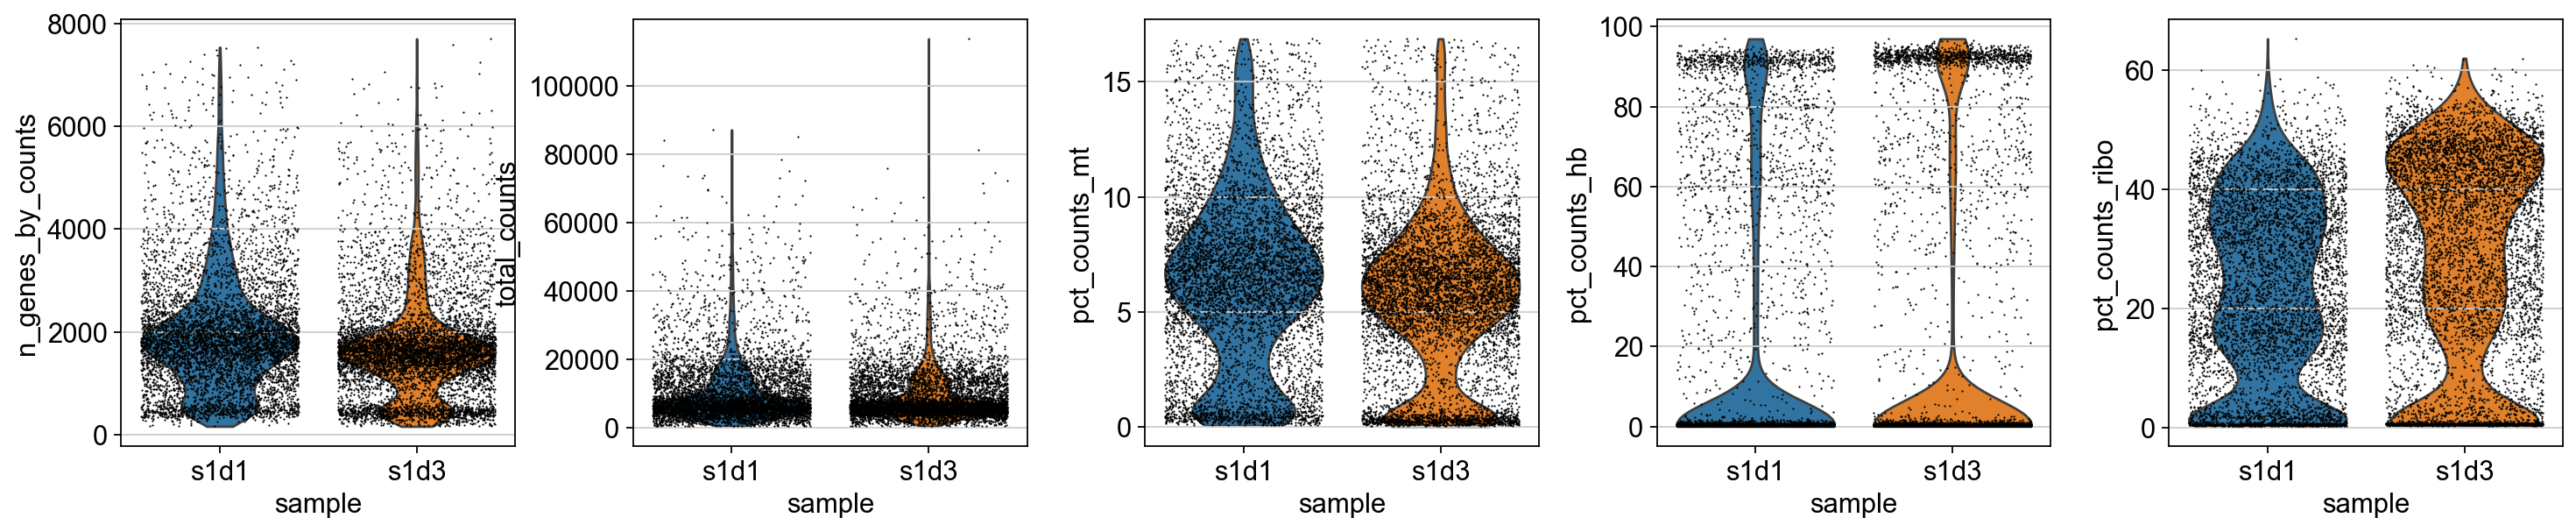

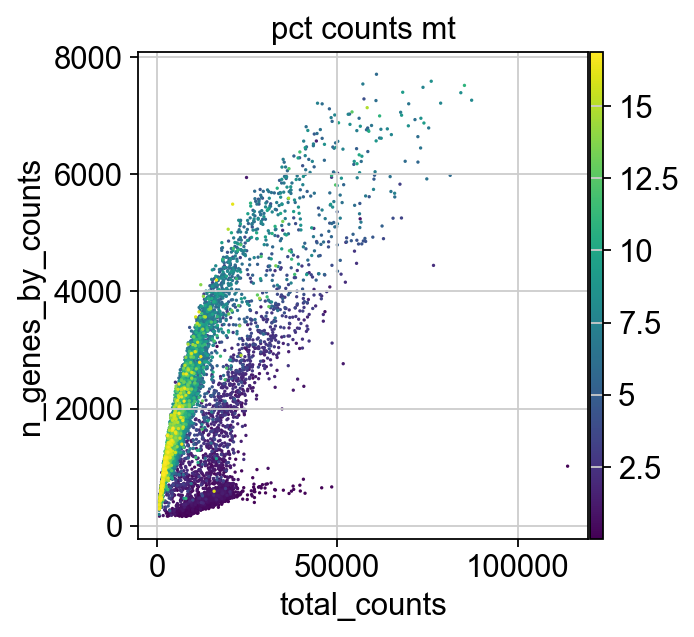

In [9]:
# Now they be looking ... better? I think ... yea, Im sure they look better
sc.pl.violin(adata,
             ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"],
             jitter= 0.4, # each dot is one cell/nucleus
             multi_panel= True,
             groupby= "sample") # you can group by observation labels

sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

### Doublet detection

As a next step, we run a doublet detection algorithm. Doublets, in general, are two cells/nuclei that got the same barcode because (in our case) they were plopped into the same well on the plate by accident. There's two different kinds of doublets:
- homotypic (same cell type, not an issue really)
- heterotypic (two different cell types, BAD! will mess up the data down the line)

The easiest way of seeing doublets would be the abnormally high counts (because they are essentially double the normal RNA amount), however, this can be wildly inaccurate. Instead, what is more commonly done, is that we run an algorithm, that randomly picks out two barcodes, averages their expression profiles and saves that as a new "artificial doublet". Then PC dimensionality reduction is run on all the cells together with the newly created artificial doublets and the nearest neighbours of the artificial doublets are analysed. Then a doublet-score is calculated based on the neighbours (fraction of artificial doublets in a cells neighbourhood) and the original two subsampled REAL cells/nuclei are being "rated/scored" for how likely it is that they are in fact a doublet. We can then threshold out cells that exceed a certain doublet score.

NOTE: It is **not recommended** to run doublet detection algorithms on aggregated data (from different batches/samples) without batch correction! This is why we specify the `batch_key`.

In [10]:
# Calling the scrublet function
sc.pp.scrublet(adata, batch_key= "sample") # we define batches, because doublet detection does not work on batched data

# Look, those have been created
adata.obs[["doublet_score", "predicted_doublet"]]
adata = adata[~adata.obs["predicted_doublet"]]

# adata.write_h5ad("CBA_3mo_SGN_QCed.h5ad", compression= "gzip")

### Normalization

Since each step of RNA sequencing introduces its own variability into the data, there's big discrepancies in the count depth in between seemingly similar cells. This is bad, mkay, for statistics, mkaay? So basically we scale the counts (read depth) of each cell in such a way that the variances in between all cells become more similar. For this there are a few common methods that are all suitable for different purposes (non-exhaustive):
- Shifted Logarithm Transformation (suited for dim-red and subsequent differential gene expression analysis), this is also the method that is recommended in the ScanPy Tutorial
- Scran Normalization (good for batch correction stuff!)
- Analytic approximation of Pearson Residuals (well suited for selecting biologically variable genes and identify rare cell types)

In general: Scaling/Normalising of counts is done to a certain "size factor" like counts-per-10k (CP10k) or counts-per-million (CPM).
ScanPy has the functions `pp.normalize_total()` for that with the parameter `target_sum` controlling the size factor.

Notes: When using logarithm shifting, it is not recommended to use fixed size values like 10^5 or 10^6 because it can lead to greater overdispersion (variability) than the original dataset contained. Use the median read depth (`np.median(adata.obs["total_counts"])`) instead!

In [11]:
# Before we change the raw data (counts) we save them to a layer to preserve
adata.layers["raw_counts"] = adata.X.copy()

C:\Users\Johann\AppData\Local\Temp\ipykernel_20868\405432336.py:2: ImplicitModificationWarning: Setting element `.layers['raw_counts']` of view, initializing view as actual.
  adata.layers["raw_counts"] = adata.X.copy()


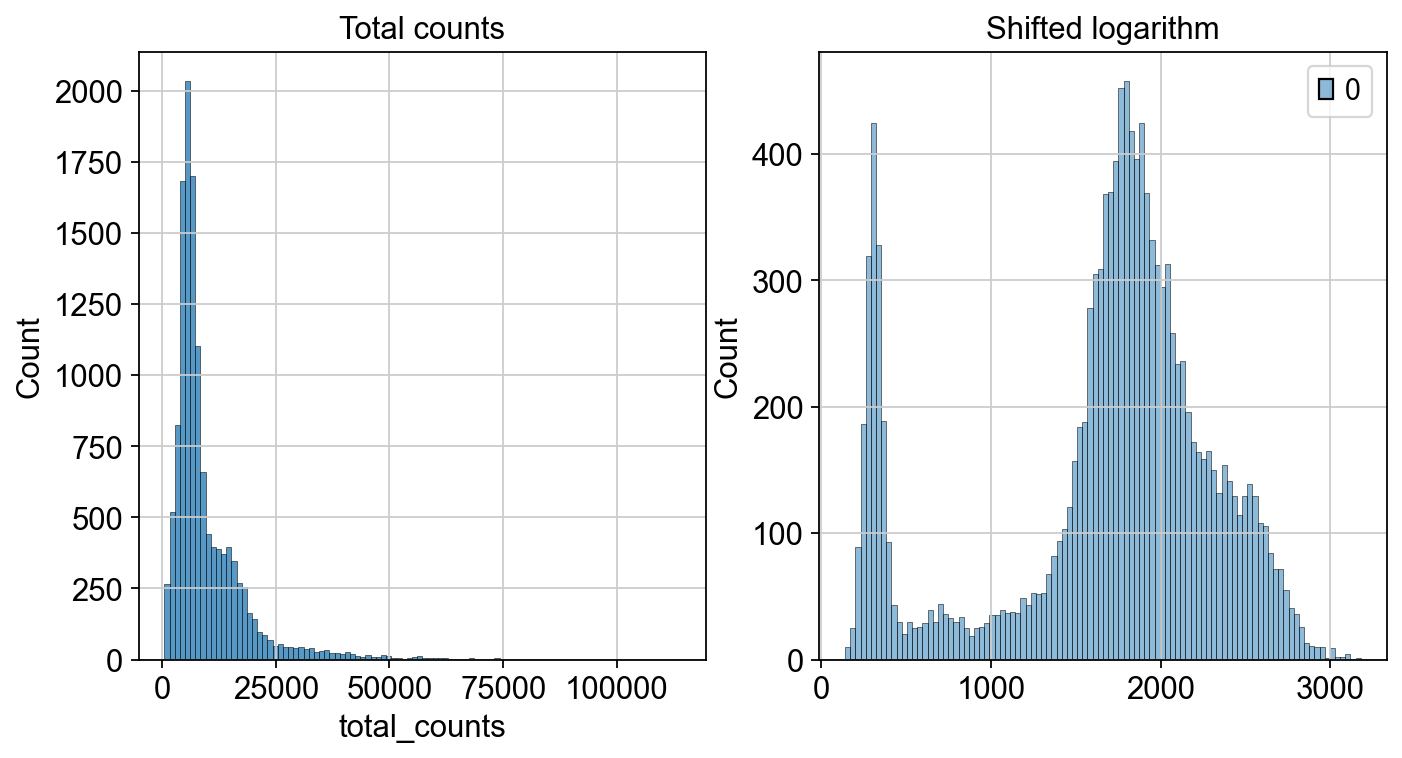

matrix([[1908.7706],
        [2702.4424],
        [2827.09  ],
        ...,
        [2668.6794],
        [1574.9957],
        [1603.8741]], shape=(12961, 1), dtype=float32)

In [12]:
# SHIFTED LOGARITHM METHOD

# Normalizing by the median
scaled_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scaled_counts["X"], copy=True)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")

sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")

plt.show()

adata.layers["log1p_norm"].sum(1) #this sums the counts of the actual matrix row wise (horizontally)
# Because when we created the layer we only saved the .X of the AnnData object

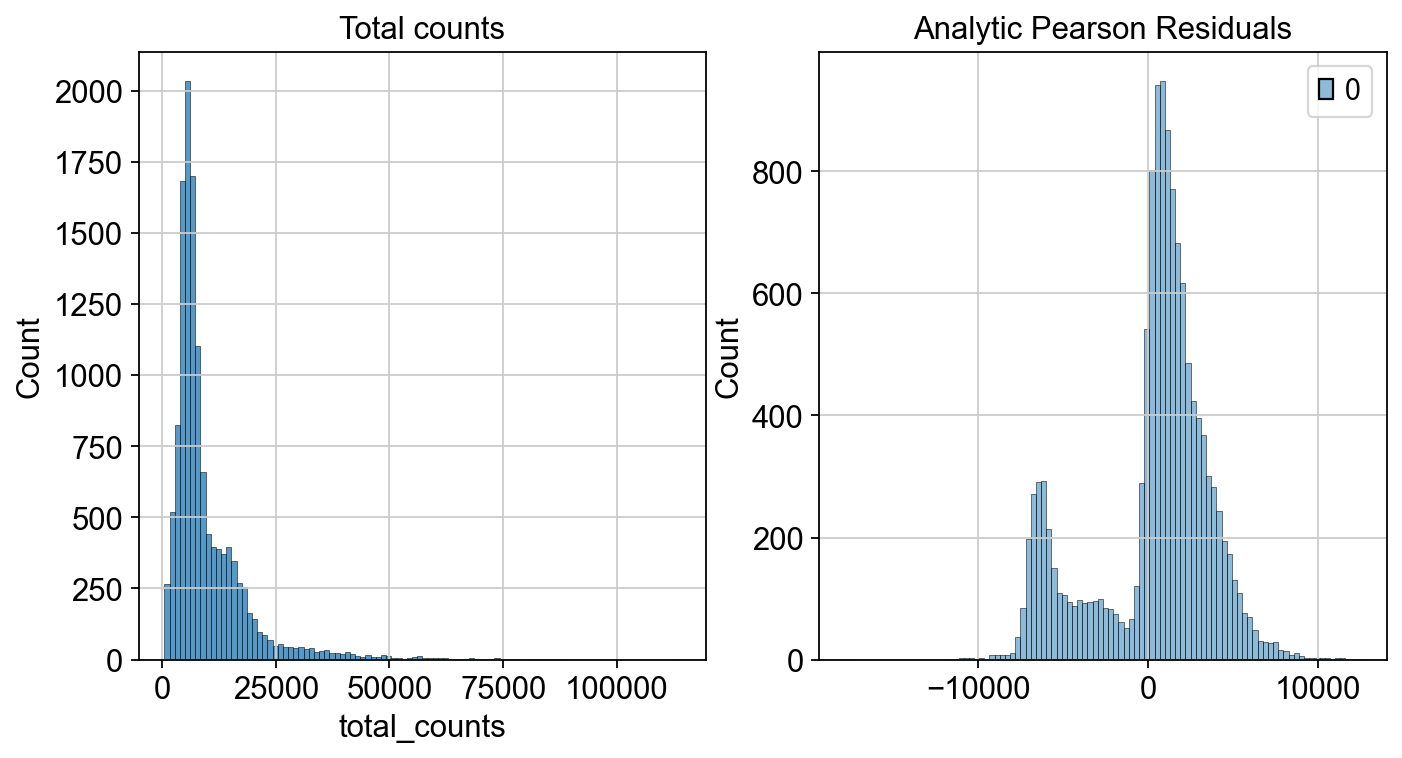

In [13]:
# Scran Normalization can be done in R ...

# PEARSON RESIDUALS METHOD
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")

sns.histplot(adata.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Analytic Pearson Residuals")

plt.show()

In [14]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

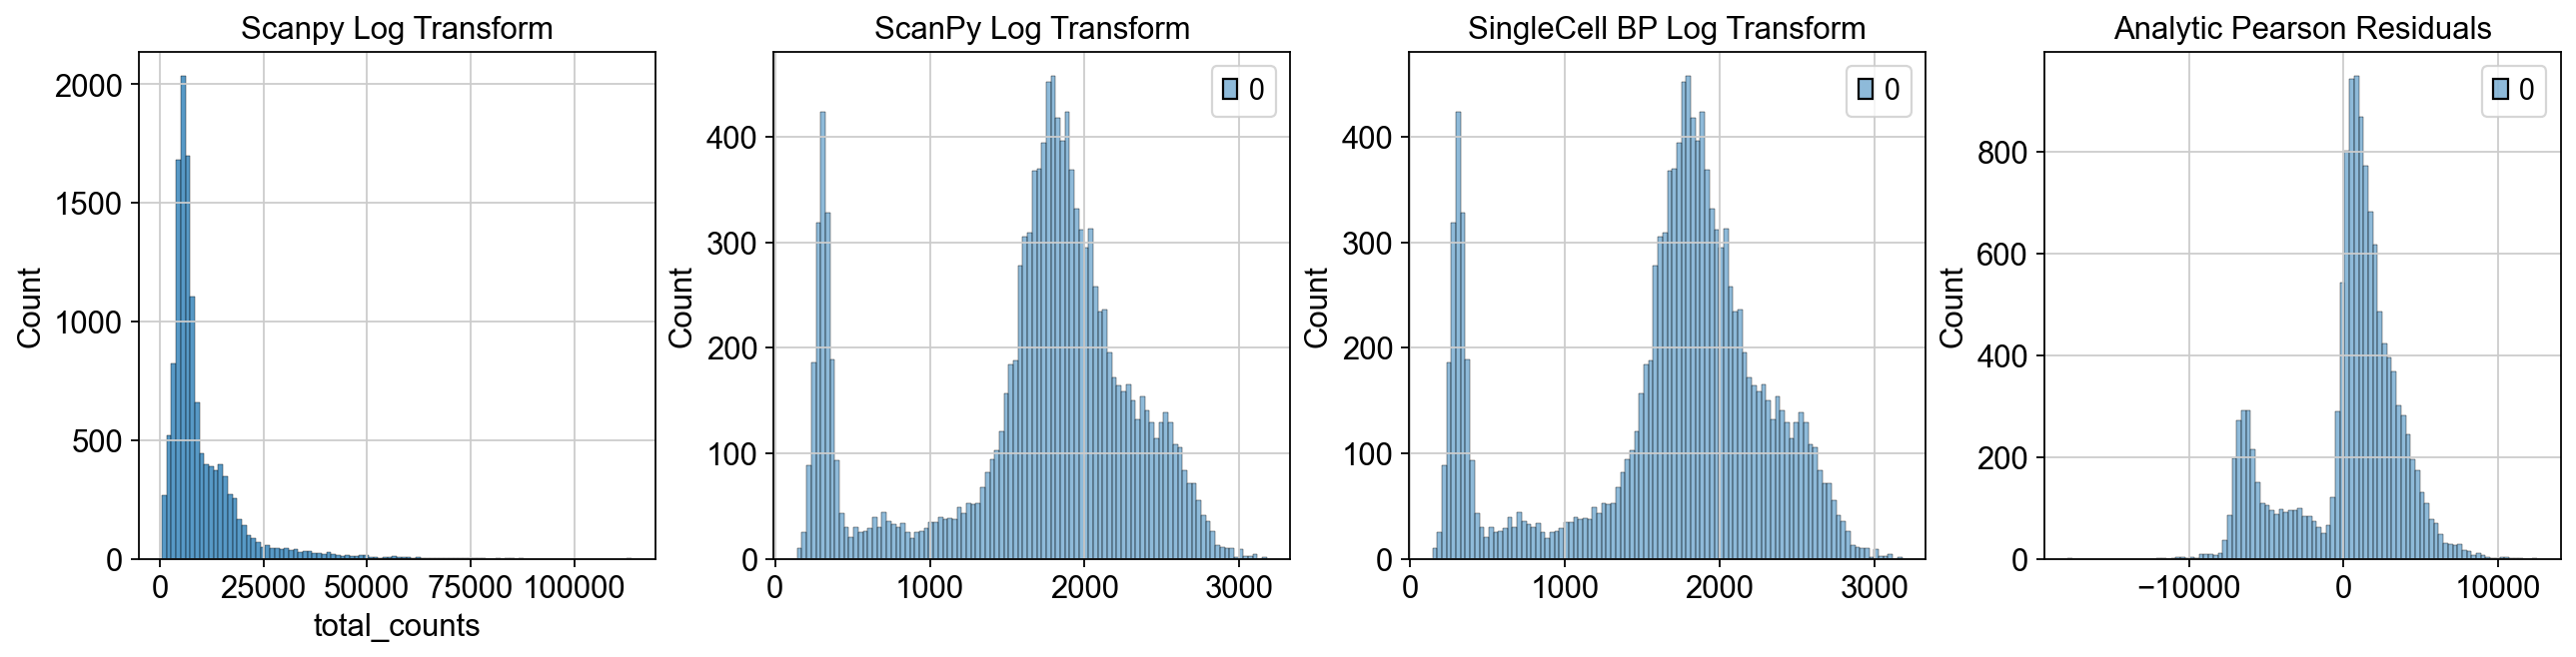

In [15]:
# Plotting for comparison!
fig, axs = plt.subplots(1,4, figsize= (16, 4), layout= "constrained")

sns.histplot(adata.obs["total_counts"], bins= 100, kde= False, ax= axs[0])
axs[0].set_title("Scanpy Log Transform")

sns.histplot(adata.X.sum(1), bins= 100, kde= False, ax= axs[1])
axs[1].set_title("ScanPy Log Transform")

sns.histplot(adata.layers["log1p_norm"].sum(1), bins= 100, kde= False, ax= axs[2])
axs[2].set_title("SingleCell BP Log Transform")

sns.histplot(adata.layers["analytic_pearson_residuals"].sum(1), bins= 100, kde= False, ax= axs[3])
axs[3].set_title("Analytic Pearson Residuals")

plt.show()

### Feature Selection

As a preliminary step to reduce the dimensionality of the data we can exclude low variability genes from the start. For this, ScanPy conveniently possesses the function `.pp.highly_variable_genes()` which takes the dataset and extracts the n-most highly variable genes according to the parameter `n_top_genes= n`.

We do this because as it is now, in the normalized count matrix, there are still a bunch of features (genes! variables! you know) that are mostly zero counts or that do not meaningfully vary across cells and thus do not represent any biological variation that we can use here. So! We find them, select them, and filter them out!

**Note:** The `.highly_variable_genes()` function calcualtes based on the normalized and log1p transformed data. It is the conventional way and as described in the ScanPy documentation. However, there is also the `.experimental.highly_variable_genes()` function which calculates stuff based on raw counts and uses pearson residuals. I will continue with this one here.

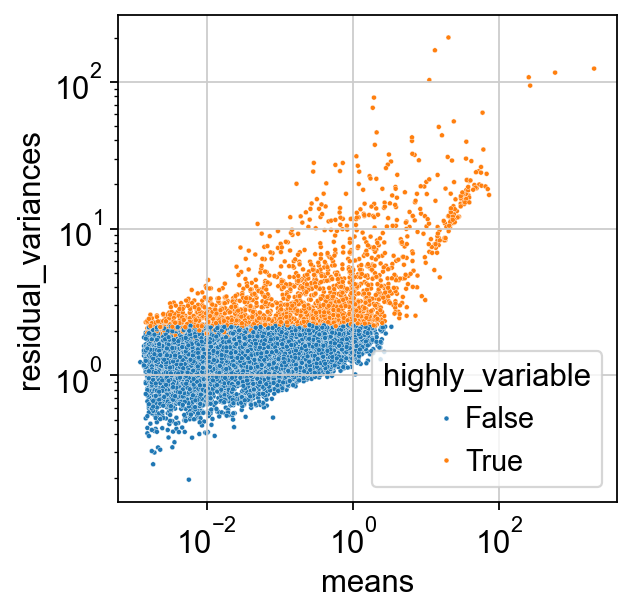

In [16]:
# Highly variable jeans
# This is the log1p based one
# sc.pp.highly_variable_genes(adata, n_top_genes= 2000, batch_key= "sample") # Still! define batches!

# This one uses Pearson Residuals
sc.experimental.pp.highly_variable_genes(adata, n_top_genes= 2000, batch_key= "sample", layer= "raw_counts") # We tell it to use the raw counts
adata.var.iloc[:, -9:-1] #it adds these annotations to the variables! We can now filter after "highly variable"
adata.var

ax = sns.scatterplot(adata.var, x= "means", y= "residual_variances", hue= "highly_variable", s= 5)
ax.set_xscale("log")
ax.set_yscale("log")

### Reduczio de la Dímenziones

Sequencing data sufferst the "curse of dimensionality" which, in a nut shell, says that higher dimensional data doesnt necessarily alway add more information and in most cases has higher redundancy and higher noise. Which is bad.
So we run **dimensionality reduction** (in addition to selecting most highly variable genes) to figure out which axes along the data explain the most variance and reduce the dimensions even further. This way we find gene sets that explain the most variability. For this several methods are used:
- t-distributed stochastic neighbour embedding (t-SNE)
    - a graph based, non-linear dimensionality reduction technique which projects the high dimensional data onto 2D or 3D components. The method defines a Gaussian probability distribution based on the high-dimensional Euclidean distances between data points
- uniform manifold approximation and projection (UMAP)
    - a graph based, non-linear dimensionality reduction technique and principally similar to t-SNE. It constructs a high dimensional graph representation of the dataset and optimizes the low-dimensional graph representation to be structurally as similar as possible to the original graph
- principal component analysis (PCA)

t-SNE and UMAP are very robus and most widely used, PCA is also still used a lot and I will do all of them and compare.

**NOTE:** They all use the normalized, log plus 1 shifted data in the "log1p" or the adata.X original layer. For the pearson residuals theres a special function `.epxerimental.pp.normalize_pearson_residuals_pca()`.

This is also a point where one could try to see batch or sample differences and then go back correct for those (using batch integration somehow presumably??)

C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\preprocessing\_pca\__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


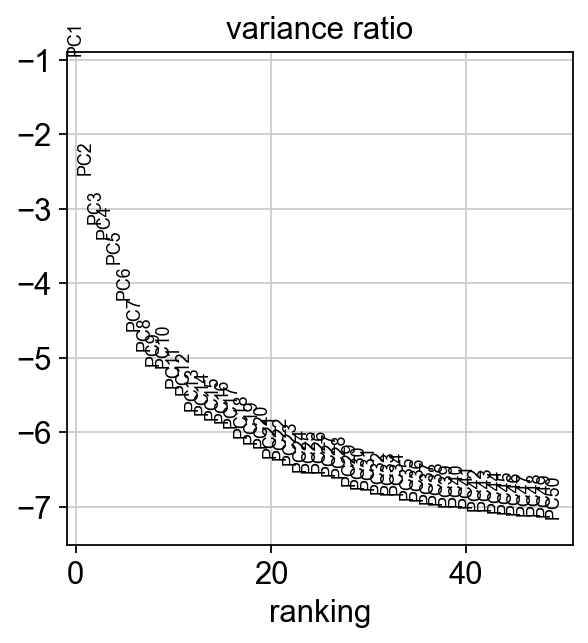

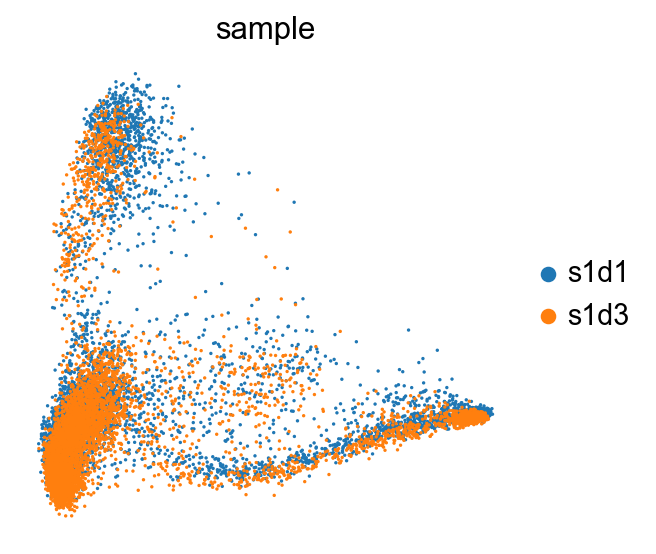

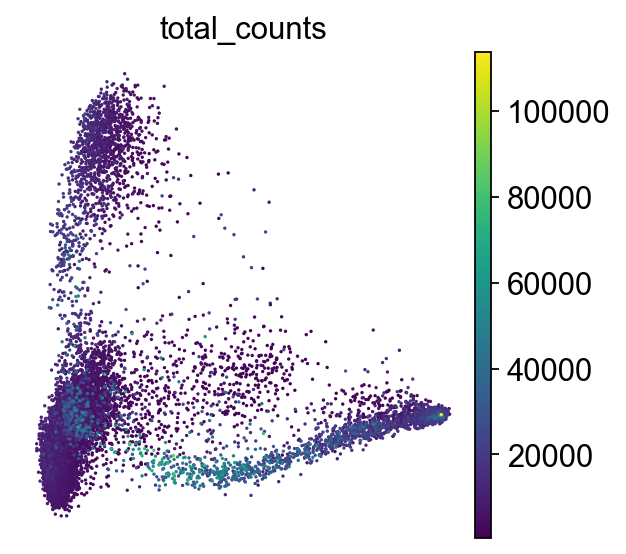

In [17]:
# PCA
sc.pp.pca(adata, svd_solver= "arpack", use_highly_variable= True)
adata # Note how .obsm and .varm were added to the AnnData object, those contain the PCA data now

# We inspect the PCA results
sc.pl.pca_variance_ratio(adata, n_pcs= 50, log= True)
sc.pl.pca_scatter(adata, color= "sample")
sc.pl.pca_scatter(adata, color= "total_counts")

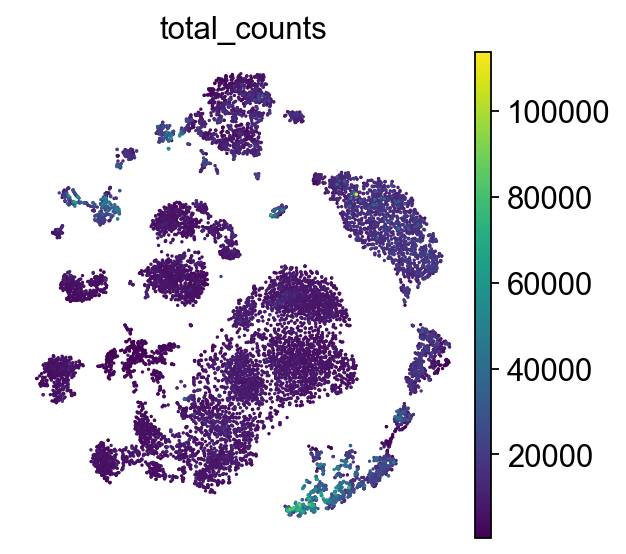

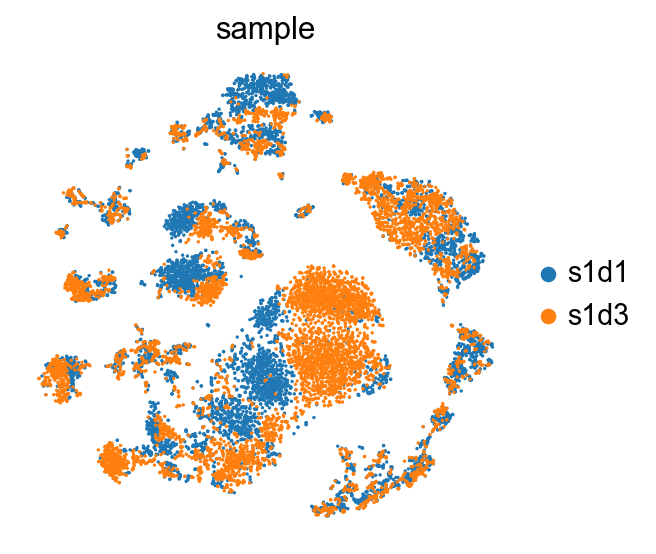

In [18]:
# t-SNE
sc.tl.tsne(adata, use_rep= "X_pca")

# Plotting to inspect
sc.pl.tsne(adata, color="total_counts")
sc.pl.tsne(adata, color="sample")

C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


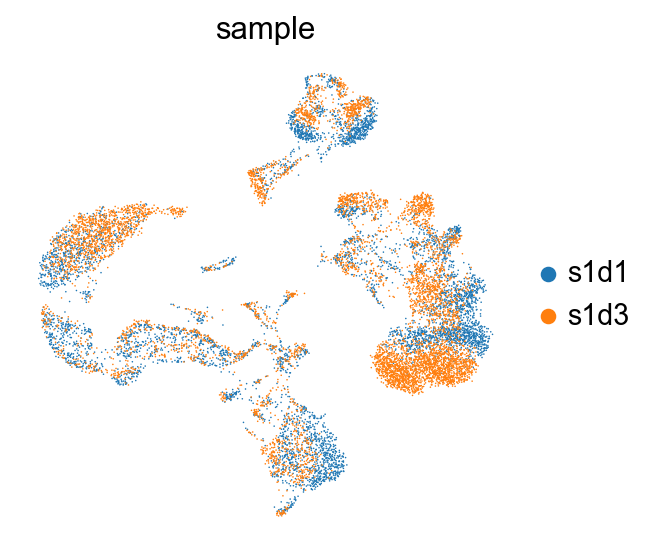

In [19]:
# UMAP
sc.pp.neighbors(adata, n_pcs= 50) # this uses the PCA representation internally
sc.tl.umap(adata)

sc.pl.umap(adata, color= "sample", size= 2) # Those look ... okay? yea

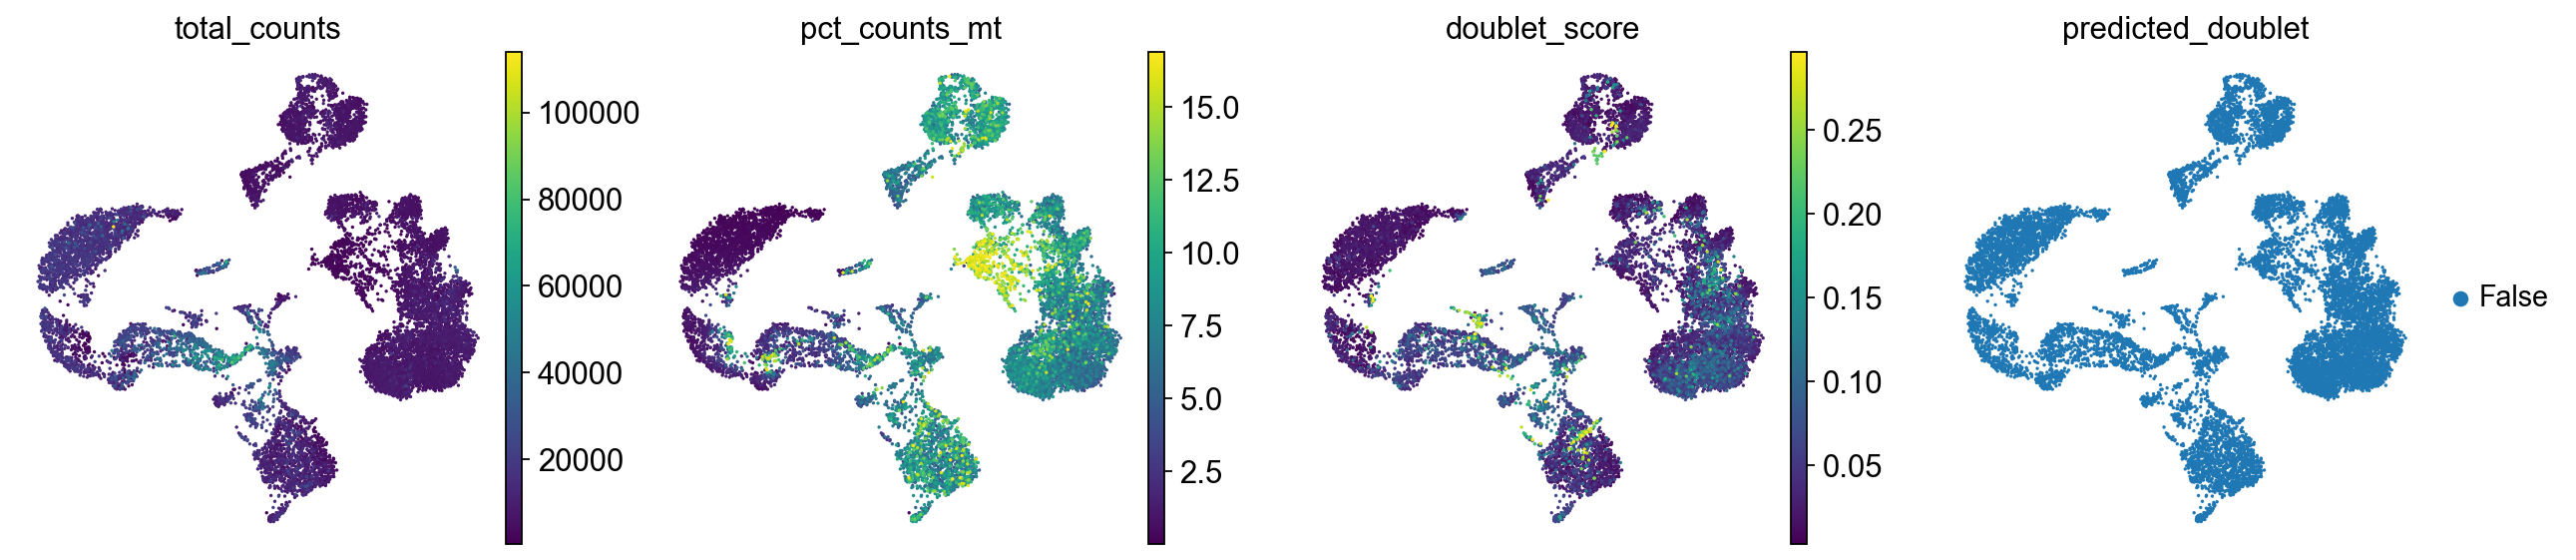

sample  n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCCAAGGATGGCT-1   s1d1               2103                 7.651596   
AAACCCAAGGCCTAGA-1   s1d1               3916                 8.273081   
AAACCCACAAGAGGCT-1   s1d1               4330                 8.373554   
AAACCCAGTCCGCAGT-1   s1d1                468                 6.150603   
AAACCCAGTGCATACT-1   s1d1               1789                 7.489971   
...                   ...                ...                      ...   
TTTGGTTGTCTCACAA-1   s1d3               3726                 8.223359   
TTTGGTTTCCGTCCTA-1   s1d3               1802                 7.497207   
TTTGTTGCAGACAATA-1   s1d3               3797                 8.242230   
TTTGTTGCATGTTACG-1   s1d3               3089                 8.035926   
TTTGTTGTCGCGCTGA-1   s1d3               1599                 7.377759   

                    total_counts  log1p_total_counts  \
AAACCCAAGGATGGCT-1        8663.0            9.066932   
AAACCCAAGGCCTAGA-1       12853.0            9.461411   
AAACCCACAAGAGGCT-1       17345.0            9.761117   
AAACCCAGTCCGCAGT-1       17290.0            9.757941   
AAACCCAGTGCATACT-1        5721.0            8.652074   
...                          ...                 ...   
TTTGGTTGTCTCACAA-1       40759.0           10.615457   
TTTGGTTTCCGTCCTA-1        7121.0            8.870944   
TTTGTTGCAGACAATA-1       13218.0            9.489410   
TTTGTTGCATGTTACG-1       27280.0           10.213945   
TTTGTTGTCGCGCTGA-1        7358.0            8.903679   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACCCAAGGATGGCT-1                   42.721921                    59.667552   
AAACCCAAGGCCTAGA-1                   35.843772                    44.262040   
AAACCCACAAGAGGCT-1                   27.662150                    38.420294   
AAACCCAGTCCGCAGT-1                   95.910931                    97.183343   
AAACCCAGTGCATACT-1                   43.121832                    55.427373   
...                                        ...                          ...   
TTTGGTTGTCTCACAA-1                   68.524743                    73.632817   
TTTGGTTTCCGTCCTA-1                   44.768993                    61.241399   
TTTGTTGCAGACAATA-1                   30.753518                    44.628537   
TTTGTTGCATGTTACG-1                   64.409824                    71.671554   
TTTGTTGTCGCGCTGA-1                   49.945637                    68.333786   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
AAACCCAAGGATGGCT-1                    69.744892                    79.348955   
AAACCCAAGGCCTAGA-1                    52.376877                    62.763557   
AAACCCACAAGAGGCT-1                    48.901701                    62.023638   
AAACCCAGTCCGCAGT-1                    98.438404                   100.000000   
AAACCCAGTGCATACT-1                    64.202063                    76.350288   
...                                         ...                          ...   
TTTGGTTGTCTCACAA-1                    78.895459                    85.372556   
TTTGGTTTCCGTCCTA-1                    70.776576                    80.775172   
TTTGTTGCAGACAATA-1                    53.691935                    64.684521   
TTTGTTGCATGTTACG-1                    78.317449                    85.054985   
TTTGTTGTCGCGCTGA-1                    76.297907                    85.063876   

                    total_counts_mt  ...  log1p_total_counts_ribo  \
AAACCCAAGGATGGCT-1            460.0  ...                 8.202756   
AAACCCAAGGCCTAGA-1           1790.0  ...                 7.450079   
AAACCCACAAGAGGCT-1            780.0  ...                 8.278174   
AAACCCAGTCCGCAGT-1             93.0  ...                 4.007333   
AAACCCAGTGCATACT-1            575.0  ...                 7.496653   
...                             ...  ...                      ...   
TTTGGTTGTCTCACAA-1           1176.0  ...                 8.087333   
TTTGGTT

In [20]:
# Inspectin QC metrics
sc.pl.umap(adata, color=["total_counts", "pct_counts_mt", "doublet_score", "predicted_doublet"])

# Saving the Data
# adata.write(r"C:\Users\Johann\Documents\Coding\Python\Master Thesis\Data\s4d8_dimensionality_reduction.h5ad")

adata.obs

### Clustering

Okay so what we did just now was dimensionality reduction, now we can use the reduced dimensions to construct clusters of similarity and introduce cellular structure. This will then help define our cell types, hopefully, in theory, at a fixed resolution.

**Cell Identitiy Annotation** is done at this step too.

For this we look at the dimension reduced (gene expression) data that we just calculated and make a k-nearest-neighbour (**KNN**) graph out of it. In this graph each node is a cell and what we want to do is find out if they belong to "communities" (just similar neighbourhoods) by euclidean distance. K is the number of cells we want to connect every other cell to in order to define the most representative cluster based on gene expression. K is usually between 5 and 100 depending on dataset size.

Calculate a **KNN graph** using a dimension reduced (through PCA or tSNE for example) dataset with `.pp.neighbour(data)` and set `n_pcs= 30-50`. Usually, there is no downside to including more PCAs as far as I understood that so knock yoself oud.

Common methods of community detection are **Louvain** or **Leiden**, the latter being the more advanced and modern one so we use that.

We can achieve Leiden clustering using the `tl.leiden()` function. It has a `resolution=` parameter. Higher resolution means smaller clusters means we detect "more" cell types but at one point you can cluster individual cells apart because of cell cycle or other differences so you cant meaningfully cluster forever.

leiden_res0_75
0     1277
1     1234
2      217
3     1641
4       52
5     1137
6      649
7     1206
8      715
9      408
10     345
11     667
12      76
13     706
14     499
15     770
16     374
17     512
18     395
19      81
Name: count, dtype: int64


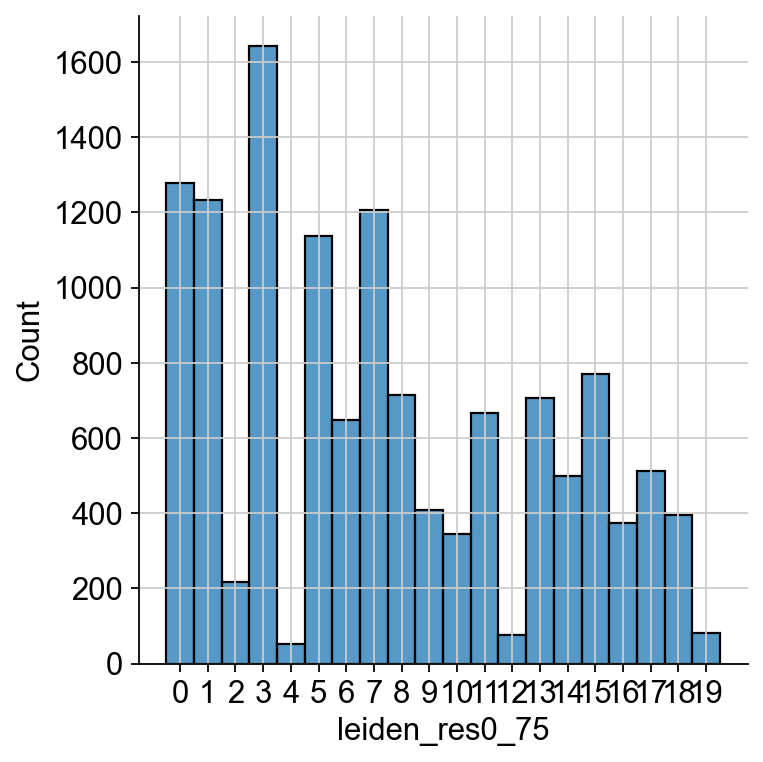

In [21]:
# Leider Clustering
# Leiden works on a KNN graph, this we alread calculated preivously by calling pp.neighbors()
# So now we can just continue with that one

# This is the default call with a res= 1.0
sc.tl.leiden(adata, flavor= "igraph", n_iterations= 2)
# We use "igraph" to provide the algorithm I think, and fixed iterations
# Speeds things up

# However we might wanna try some different resolutions and save them to their own keys
# We can recluster with a bunch of different resolutions and see which one works best for annotating
sc.tl.leiden(adata, flavor= "igraph", n_iterations= 2, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, flavor= "igraph", n_iterations= 2, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, flavor= "igraph", n_iterations= 2, key_added="leiden_res0_75", resolution=0.75)
sc.tl.leiden(adata, flavor= "igraph", n_iterations= 2, key_added="leiden_res1", resolution=1.0)

# A leiden key is added to .obs that determines the cluster identity of each cell
adata.obs[["leiden", "leiden_res1", "leiden_res0_5"]] # Some of them

print(adata.obs["leiden_res0_75"].value_counts().sort_index()) # You can now reference cells belonging to one cluster by leiden obs
# And see how many there are

sns.displot(adata.obs["leiden_res0_75"])

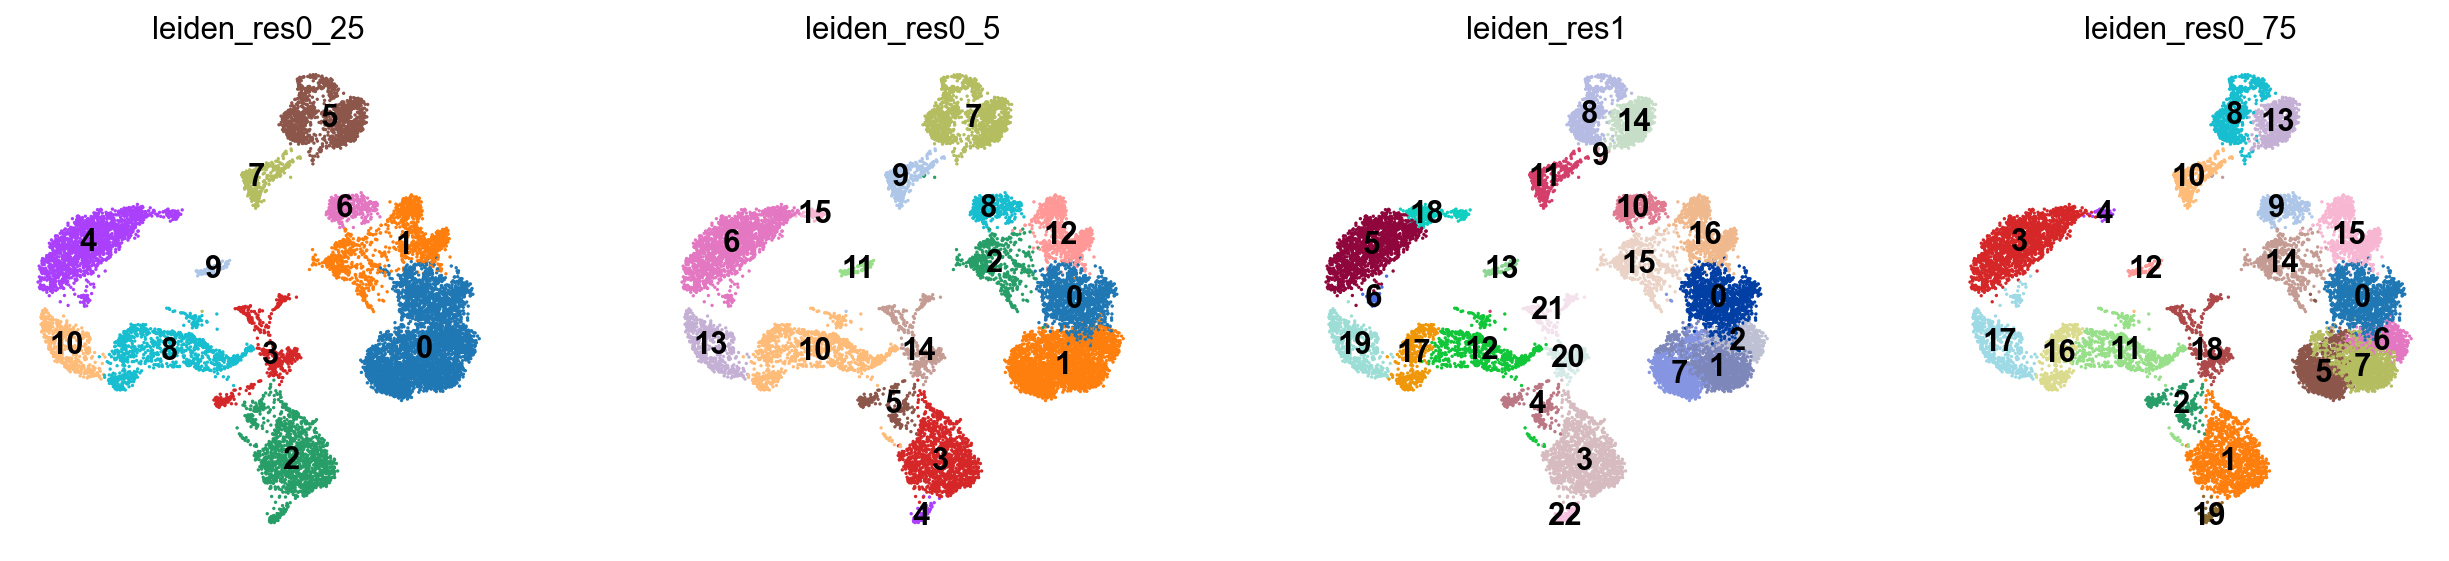

In [22]:
# Plotting our clusters
sc.pl.umap(
    adata,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1", "leiden_res0_75"],
    legend_loc="on data",
)

### Re-check QC

Now that we have our first clusters we can recheck our quality control and go back to change stuff if necessary. So what we basically do is, check clusters agains doublet scores to see if any clusters might only be a result of doublets, and we check clusters against counts of genes per cell and the percentage of mitochondrial genes. So in the best case, no clusters are predominantly doublets or mitochondria, or have super highly concentrated gene expression numbers

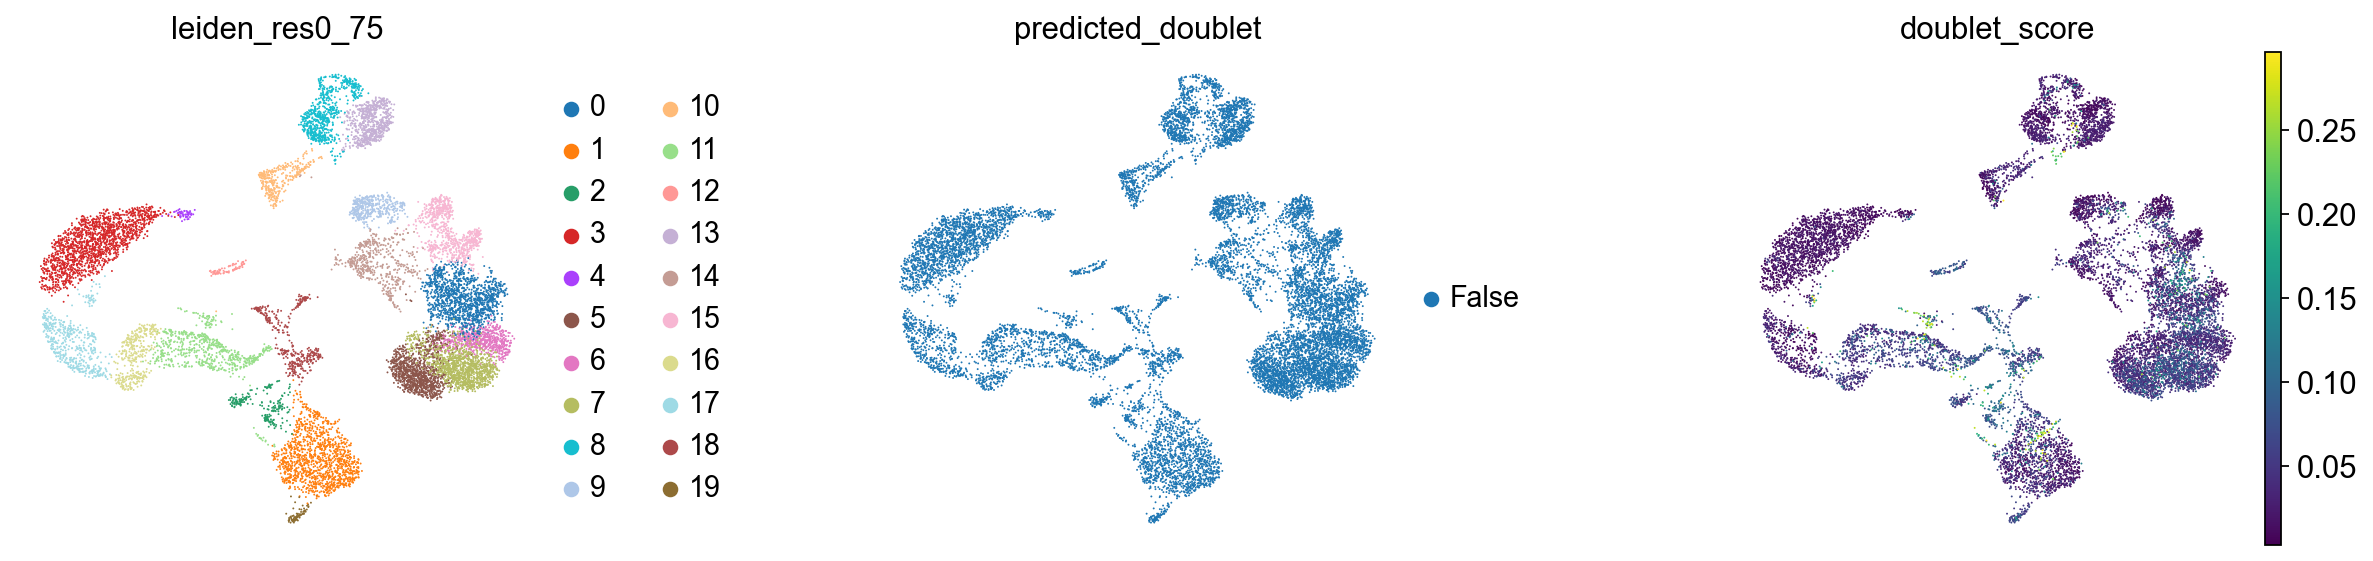

In [23]:
sc.pl.umap(
    adata,
    color=["leiden_res0_75", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3)

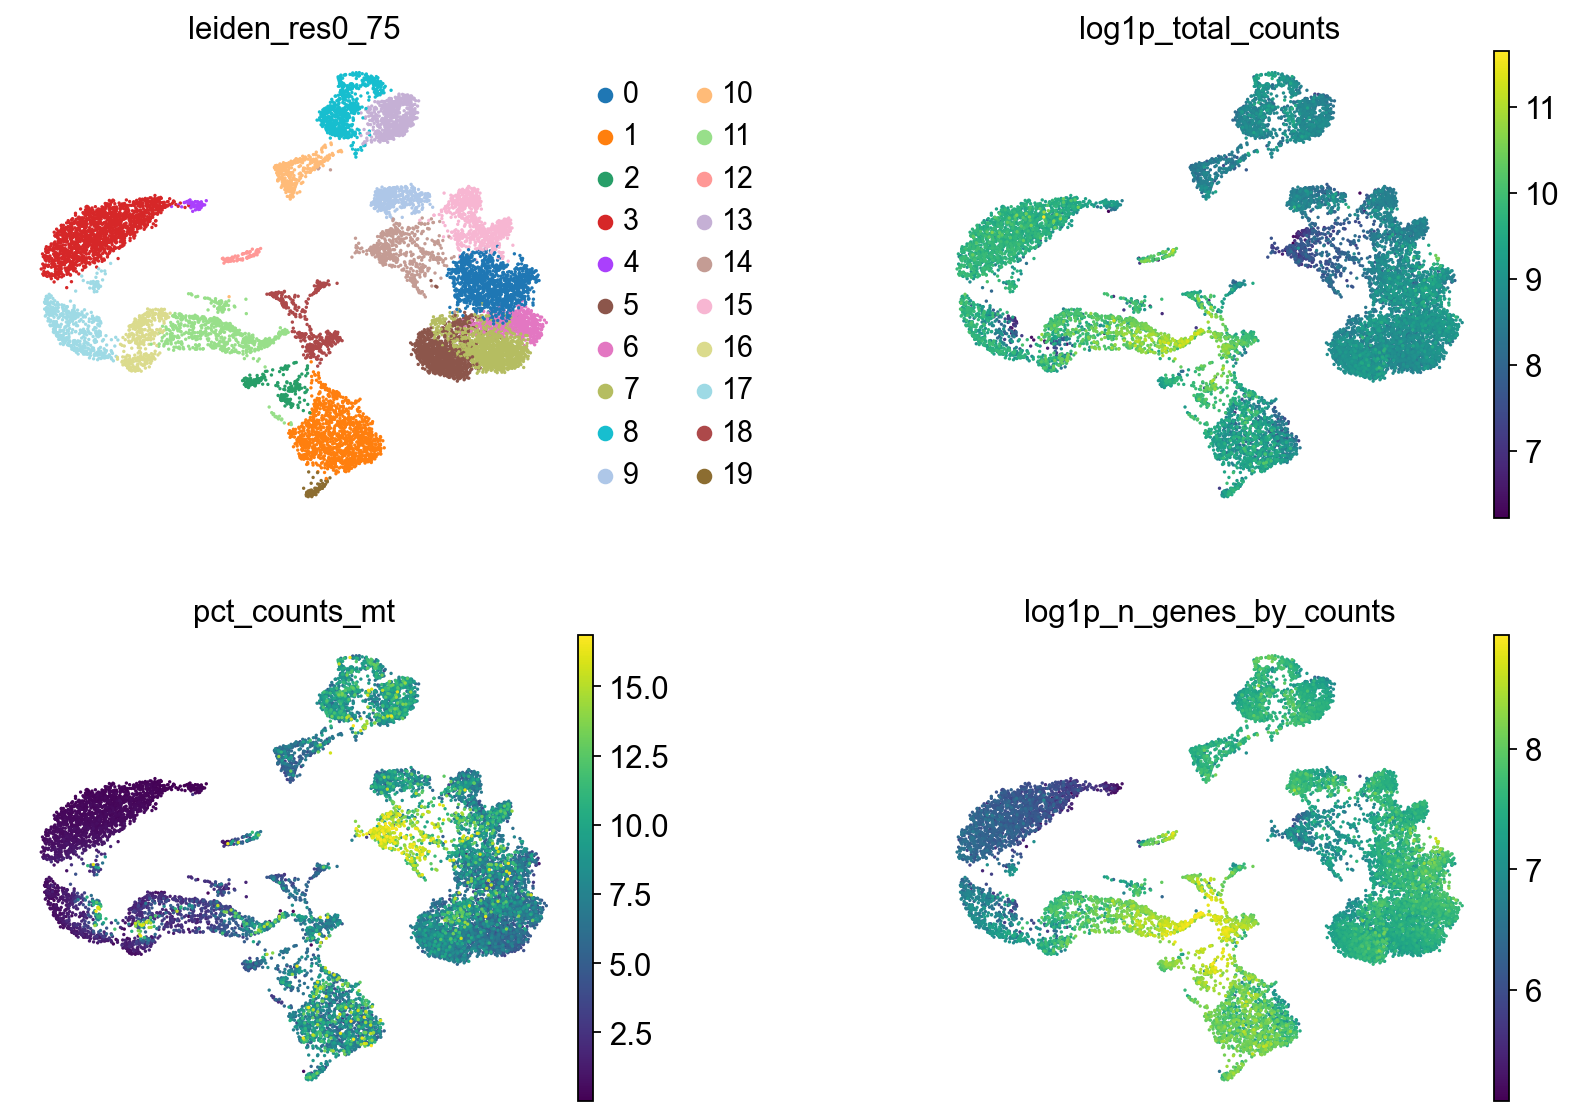

In [24]:
sc.pl.umap(
    adata,
    color=["leiden_res0_75", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2)

### Annotation

Cell type annotation! Okay! So for this we need marker genes. Where do we get marker genes? Idk, some data base probably. Once we have a set of marker genes we put it in a dictionary with lists. Then we rank the genes within our clusters after expression, look at the most highly expressed genes in each cluster, cross reference them with the marker genes, and guess the cell identitiy based on empiric data! Whoopie.
You can also do this based on interventions, like drugs, disease phenotypes, or batches or whatever. Annotation isnt necessarily only cell identity. You can also cluster the same cells based on pathogenesis or other things.

**NOTE:** This usually requires a few rounds of reclustering with different resolutions and re-annotating until everything matches up.

In [1]:
# New stuff we need for annotations
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

from numba.core.errors import NumbaDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

import urllib.request
from pathlib import Path

import celltypist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scarches as sca
import seaborn as sns
from celltypist import models
from scipy.sparse import csr_matrix

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

sc.set_figure_params(figsize=(5, 5))

In order to use the mouse gastrulation seqFISH datsets, please install squidpy (see https://github.com/scverse/squidpy).
C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'read' from 'anndata' (C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\anndata\__init__.py)